In [336]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.basic_cleaning import *

In [337]:
train_data = pl.read_csv("train_data.csv").pipe(reduce_memory_usage)
test_data = pl.read_csv("test_data.csv").pipe(reduce_memory_usage)
train_data.shape,test_data.shape

((4907, 19), (2108, 19))

In [338]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

In [339]:
for col in cat_cols[:-1]:
    train_data=train_data.with_columns(train_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))
    test_data=test_data.with_columns(test_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))

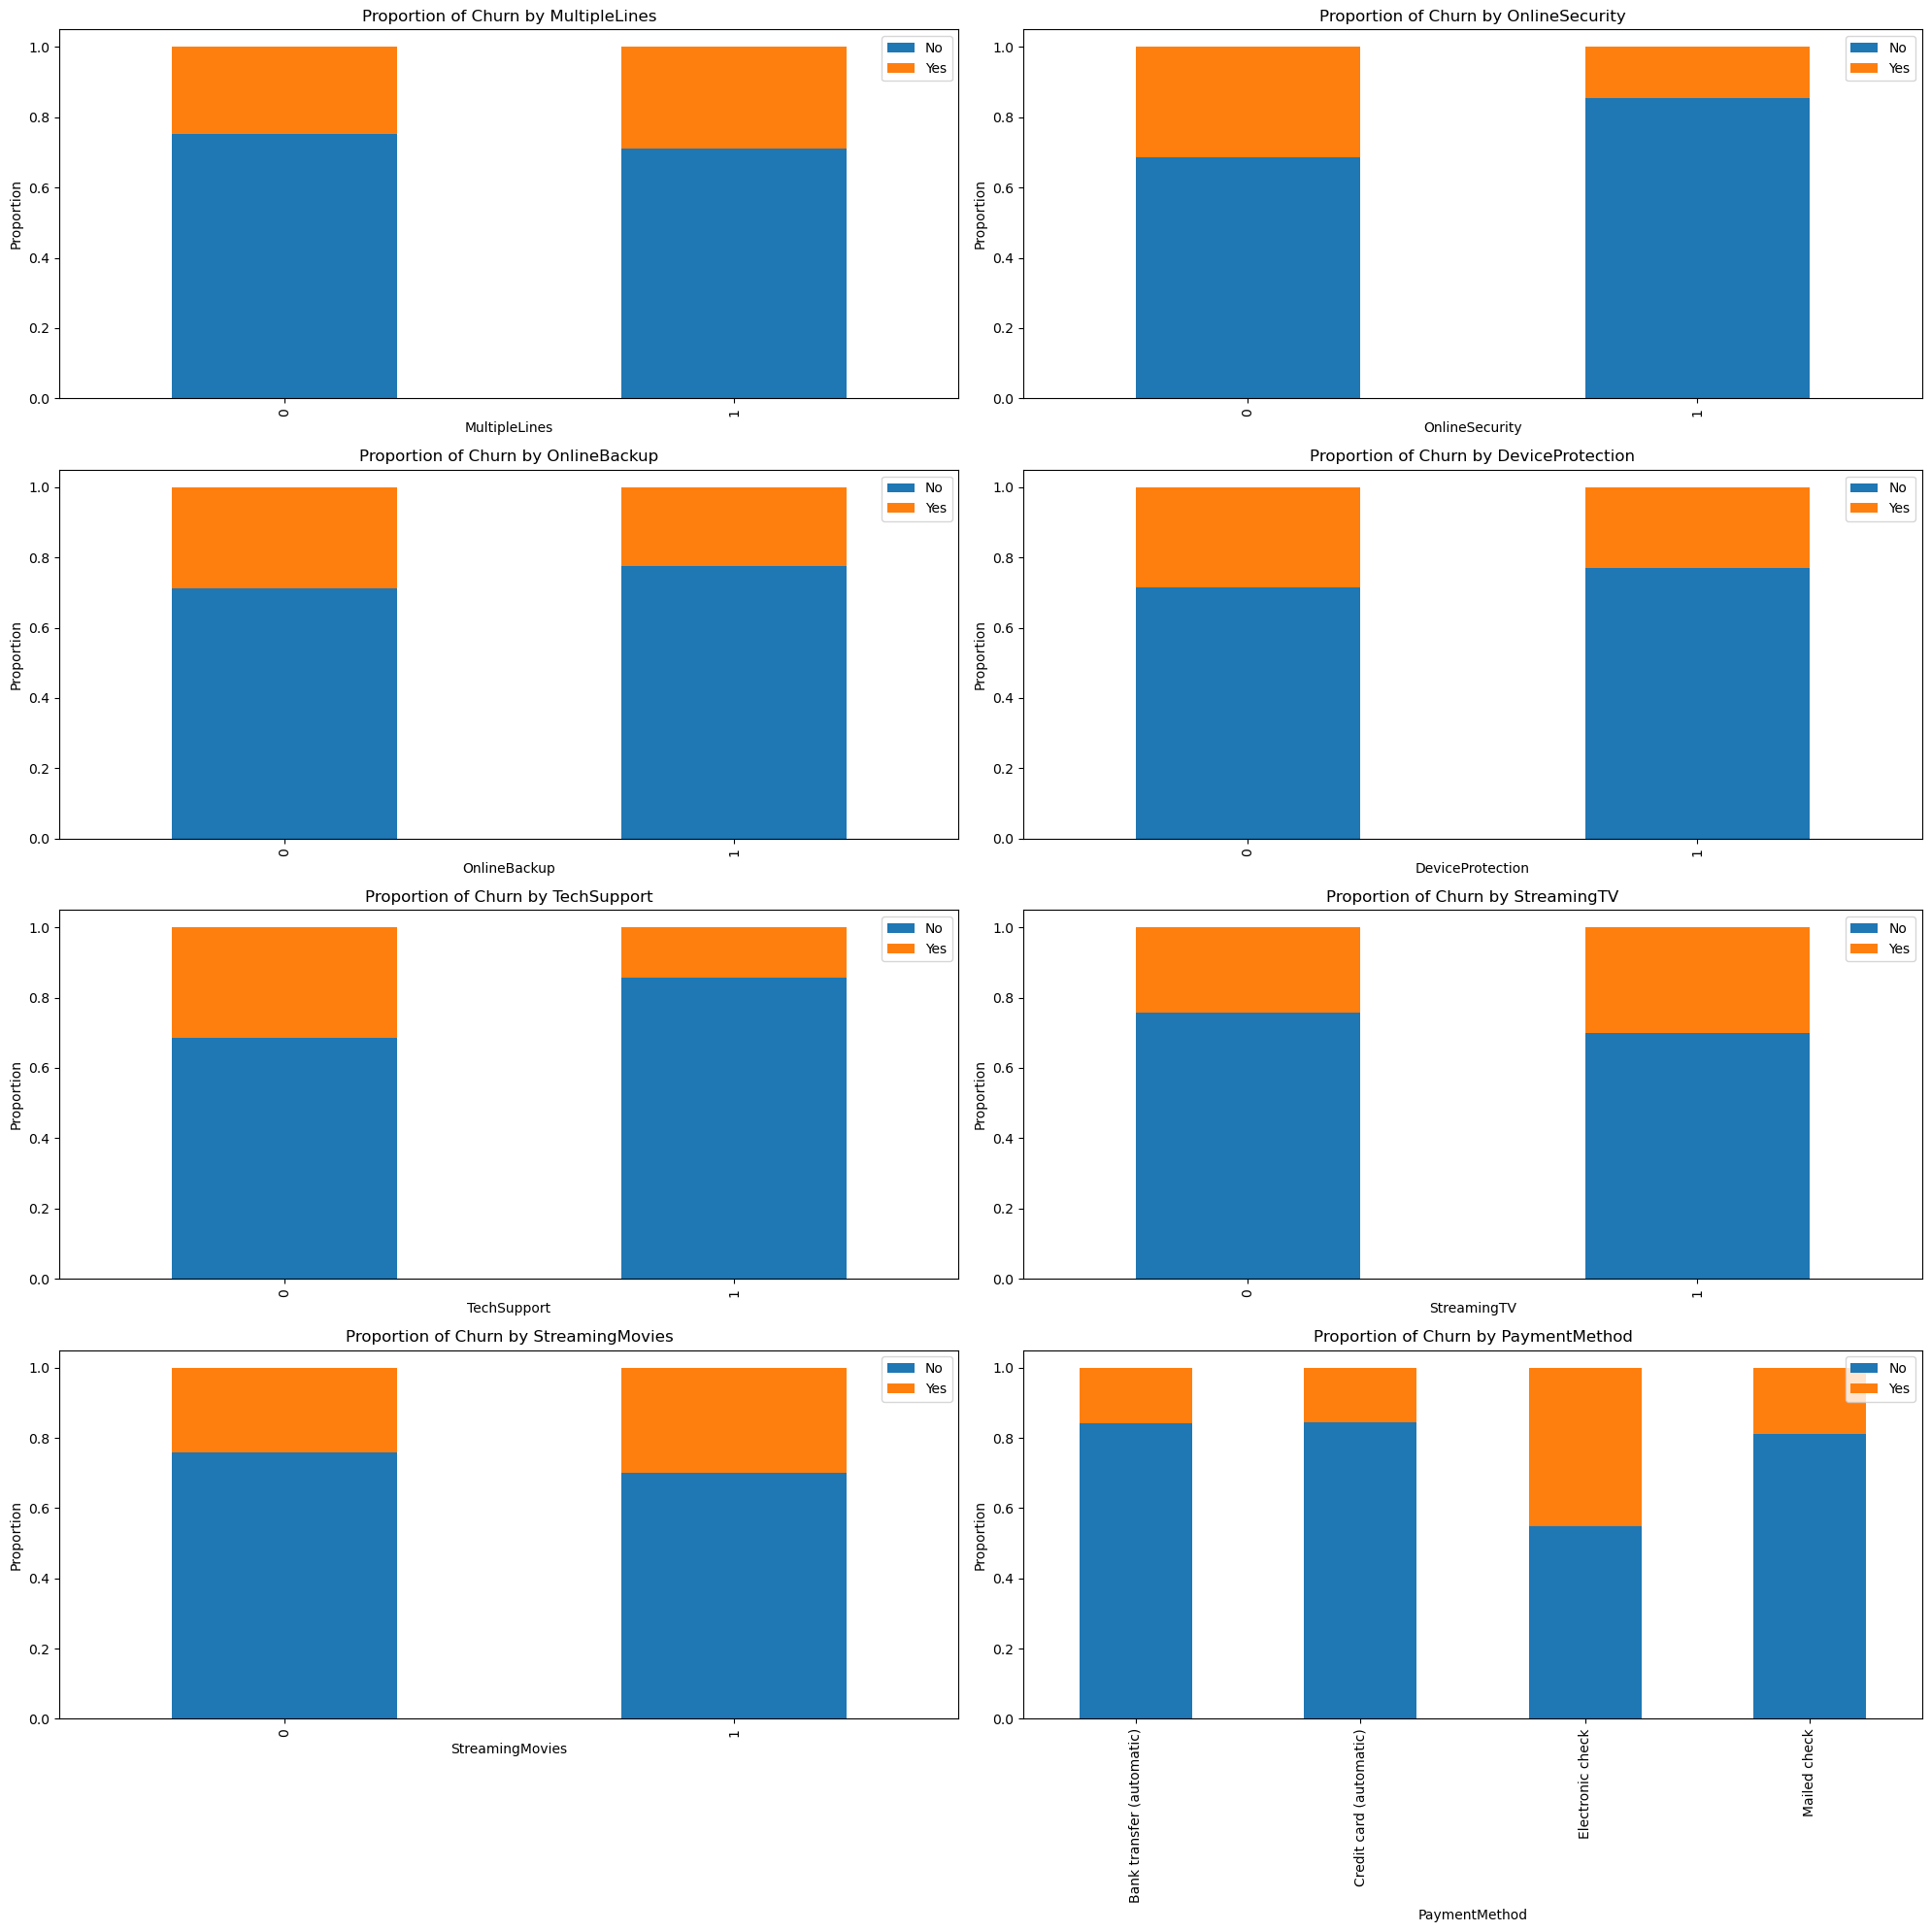

In [340]:
cat_proportion_plot(train_data.to_pandas(),cat_cols,"Churn")

In [341]:
train_data=train_data.with_columns(train_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")
test_data=test_data.with_columns(test_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")

In [342]:
train_data=train_data.with_columns(pl.Series((train_data["StreamingMovies"] | train_data["StreamingTV"]) & train_data["TechSupport"]).alias("StreamersWithTechSupport")).drop("StreamingMovies","StreamingTV")
train_data=train_data.with_columns(pl.Series(train_data["OnlineSecurity"] & train_data["DeviceProtection"] & train_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
train_data=train_data.with_columns(pl.Series(train_data['Partner'] & train_data['Dependents']).alias("Family")).drop("Partner","Dependents")
train_data=train_data.with_columns(pl.Series(train_data['PaperlessBilling'] & train_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
train_data=train_data.with_columns(pl.Series(train_data["StreamersWithTechSupport"] & train_data["Safer"] & train_data['Family']).alias("All"))


test_data=test_data.with_columns(pl.Series((test_data["StreamingMovies"] | test_data["StreamingTV"]) & test_data["TechSupport"]).alias("StreamersWithTechSupport")).drop("StreamingMovies","StreamingTV")
test_data=test_data.with_columns(pl.Series(test_data["OnlineSecurity"] & test_data["DeviceProtection"] & test_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
test_data=test_data.with_columns(pl.Series(test_data['Partner'] & test_data['Dependents']).alias("Family")).drop("Partner","Dependents")
test_data=test_data.with_columns(pl.Series(test_data['PaperlessBilling'] & test_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
test_data=test_data.with_columns(pl.Series(test_data["StreamersWithTechSupport"] & test_data["Safer"] & test_data['Family']).alias("All"))

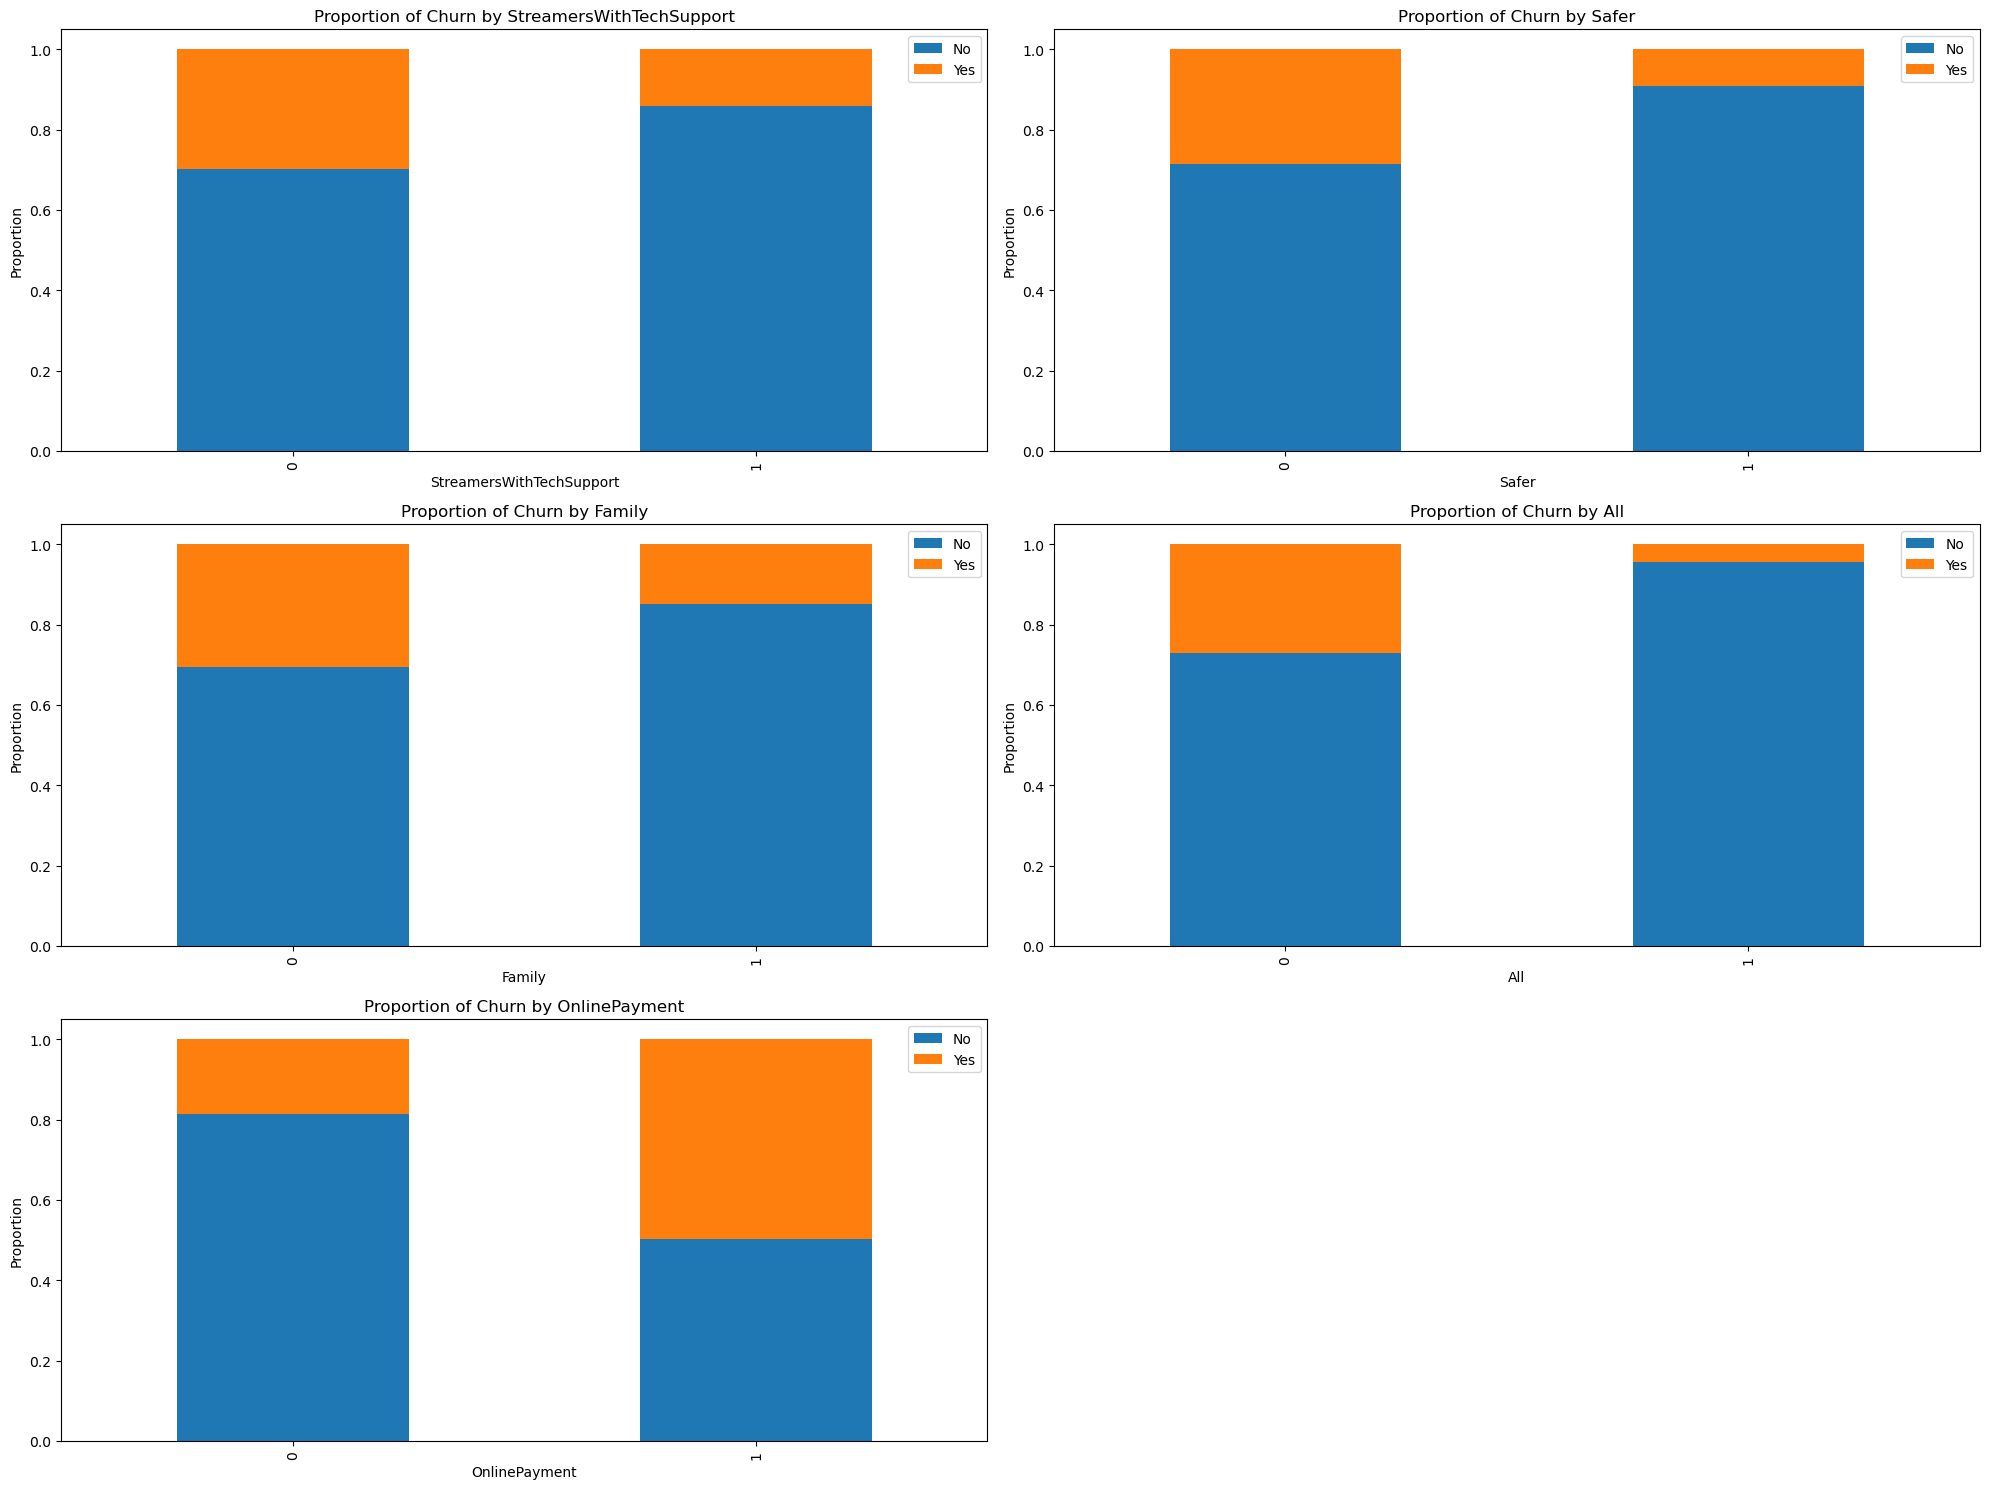

In [343]:
cat_proportion_plot(train_data,["StreamersWithTechSupport","Safer","Family","All","OnlinePayment"],"Churn")

In [344]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

Non Binary Features

In [345]:
non_binary_cols=[col for col in num_cols if len(train_data[col].unique())>2]
binary_cols=[col for col in num_cols if len(train_data[col].unique())==2]
non_binary_cols

['tenure', 'InternetService', 'Contract', 'MonthlyCharges', 'TotalCharges']

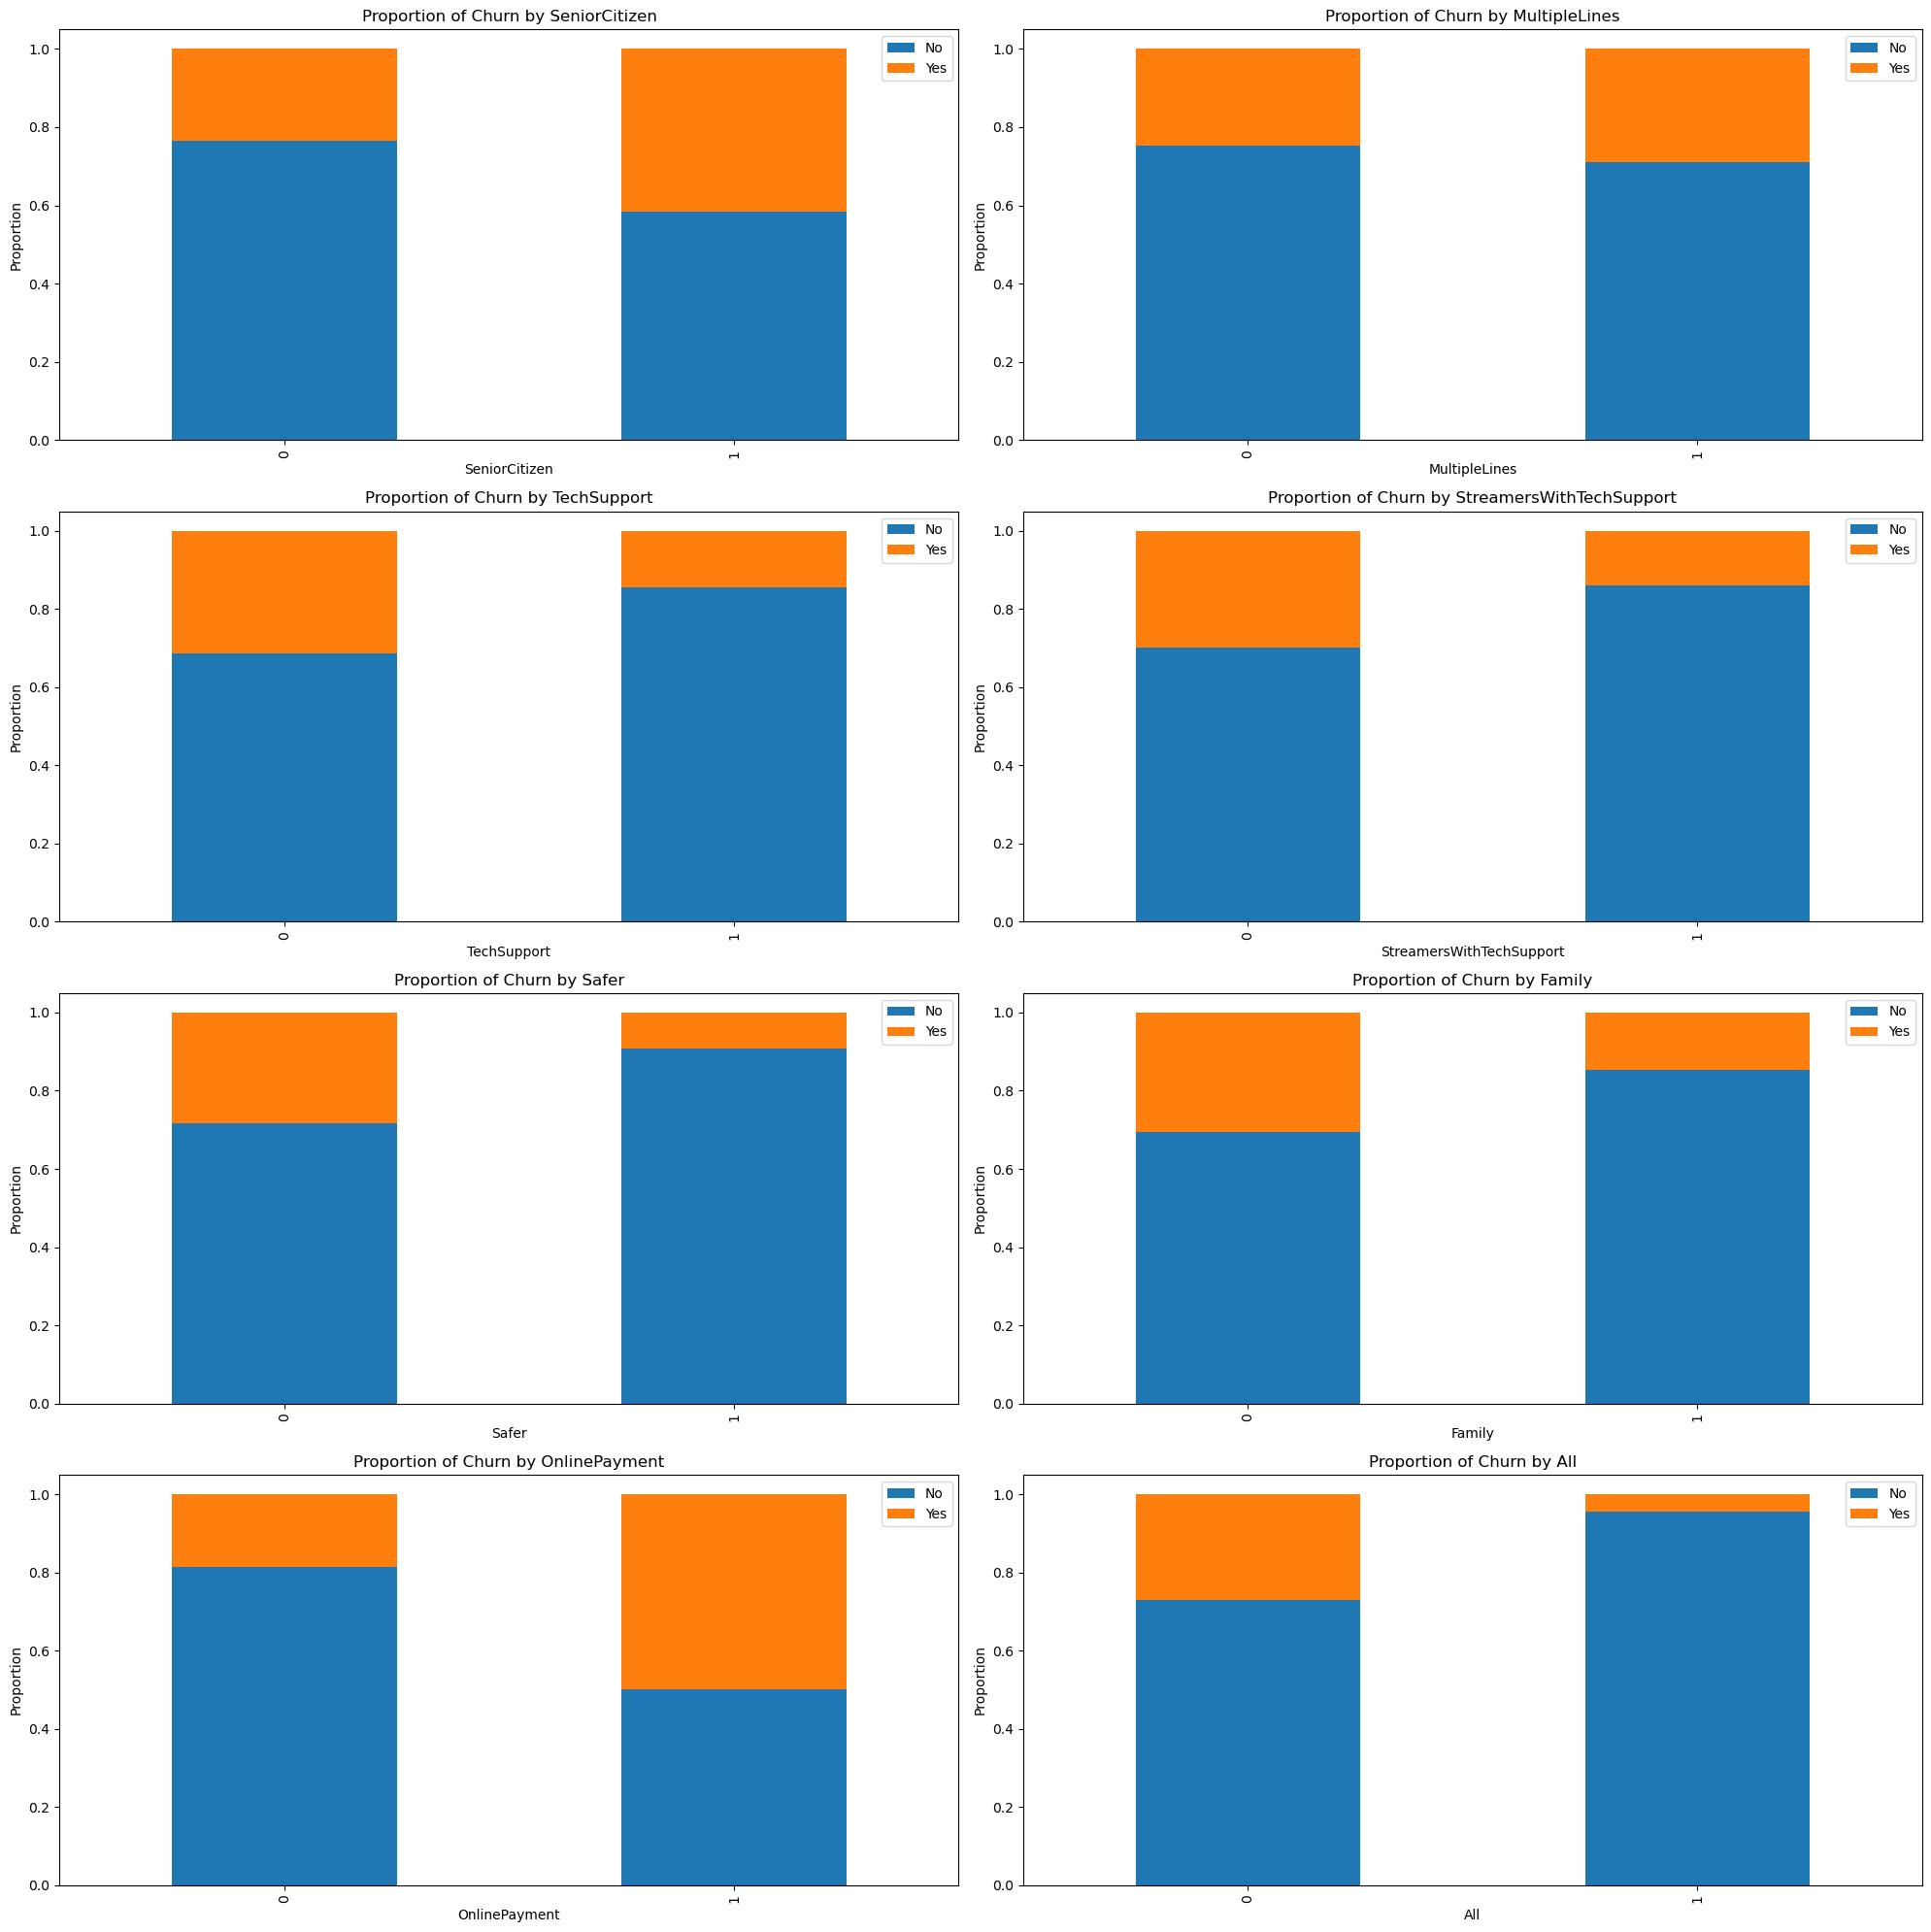

In [346]:
cat_proportion_plot(train_data,binary_cols,"Churn")

In [347]:
perform_non_normal_kruskal_hypothesis(train_data,binary_cols,"Churn")

Kruskal-Wallis H-statistic: 111.72166139262728 P-value: 4.1116574484464326e-26
There is a significant difference in Churn between different SeniorCitizen categories.

Kruskal-Wallis H-statistic: 11.540928244135756 P-value: 0.0006808063996668083
There is a significant difference in Churn between different MultipleLines categories.

Kruskal-Wallis H-statistic: 150.06129649919154 P-value: 1.6809770868271914e-34
There is a significant difference in Churn between different TechSupport categories.

Kruskal-Wallis H-statistic: 103.86875514627341 P-value: 2.1617176638032165e-24
There is a significant difference in Churn between different StreamersWithTechSupport categories.

Kruskal-Wallis H-statistic: 84.8463472349599 P-value: 3.2247600026971634e-20
There is a significant difference in Churn between different Safer categories.

Kruskal-Wallis H-statistic: 118.03725781722639 P-value: 1.701614564785628e-27
There is a significant difference in Churn between different Family categories.

Kruskal-

# Multivariate Analysis

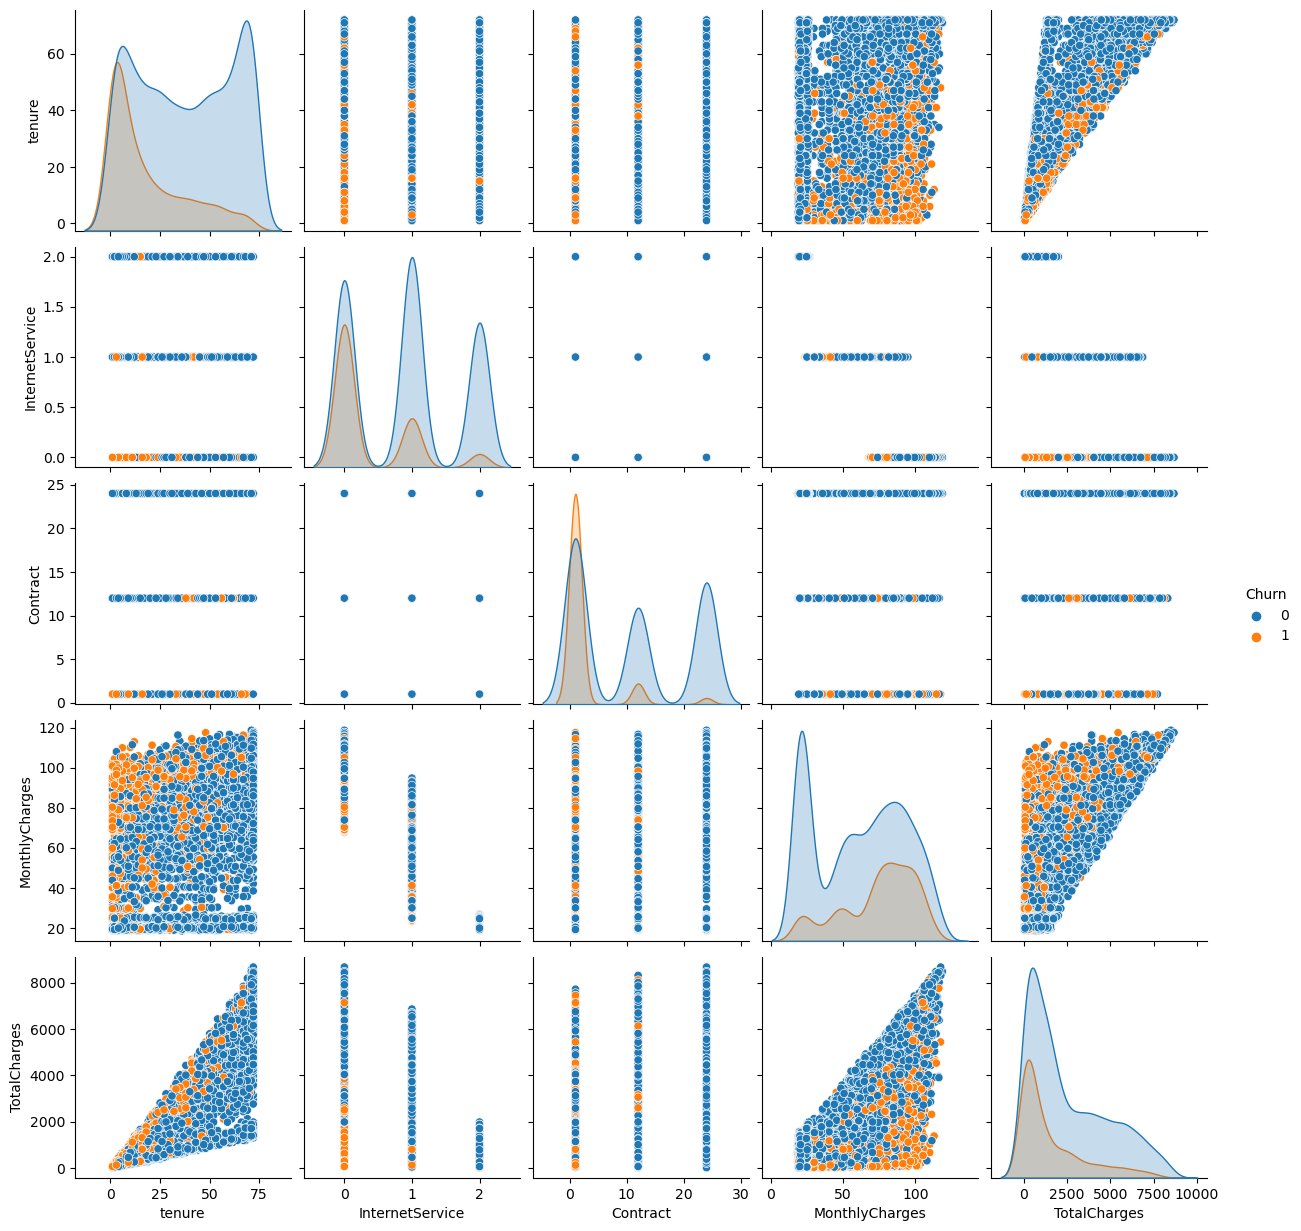

In [348]:
sns.pairplot(train_data[non_binary_cols+["Churn"]].to_pandas(),hue='Churn')

In [349]:
px.scatter_3d(train_data,x=train_data["TotalCharges"]/train_data['tenure']*train_data["Contract"],y="MonthlyCharges",z="tenure",color="Churn")

In [350]:
train_data=train_data.with_columns(pl.Series(train_data["TotalCharges"]/train_data['tenure']*train_data["Contract"]).alias("AverageChargesBasedOnContract"))
test_data=test_data.with_columns(pl.Series(test_data["TotalCharges"]/test_data['tenure']*test_data["Contract"]).alias("AverageChargesBasedOnContract"))

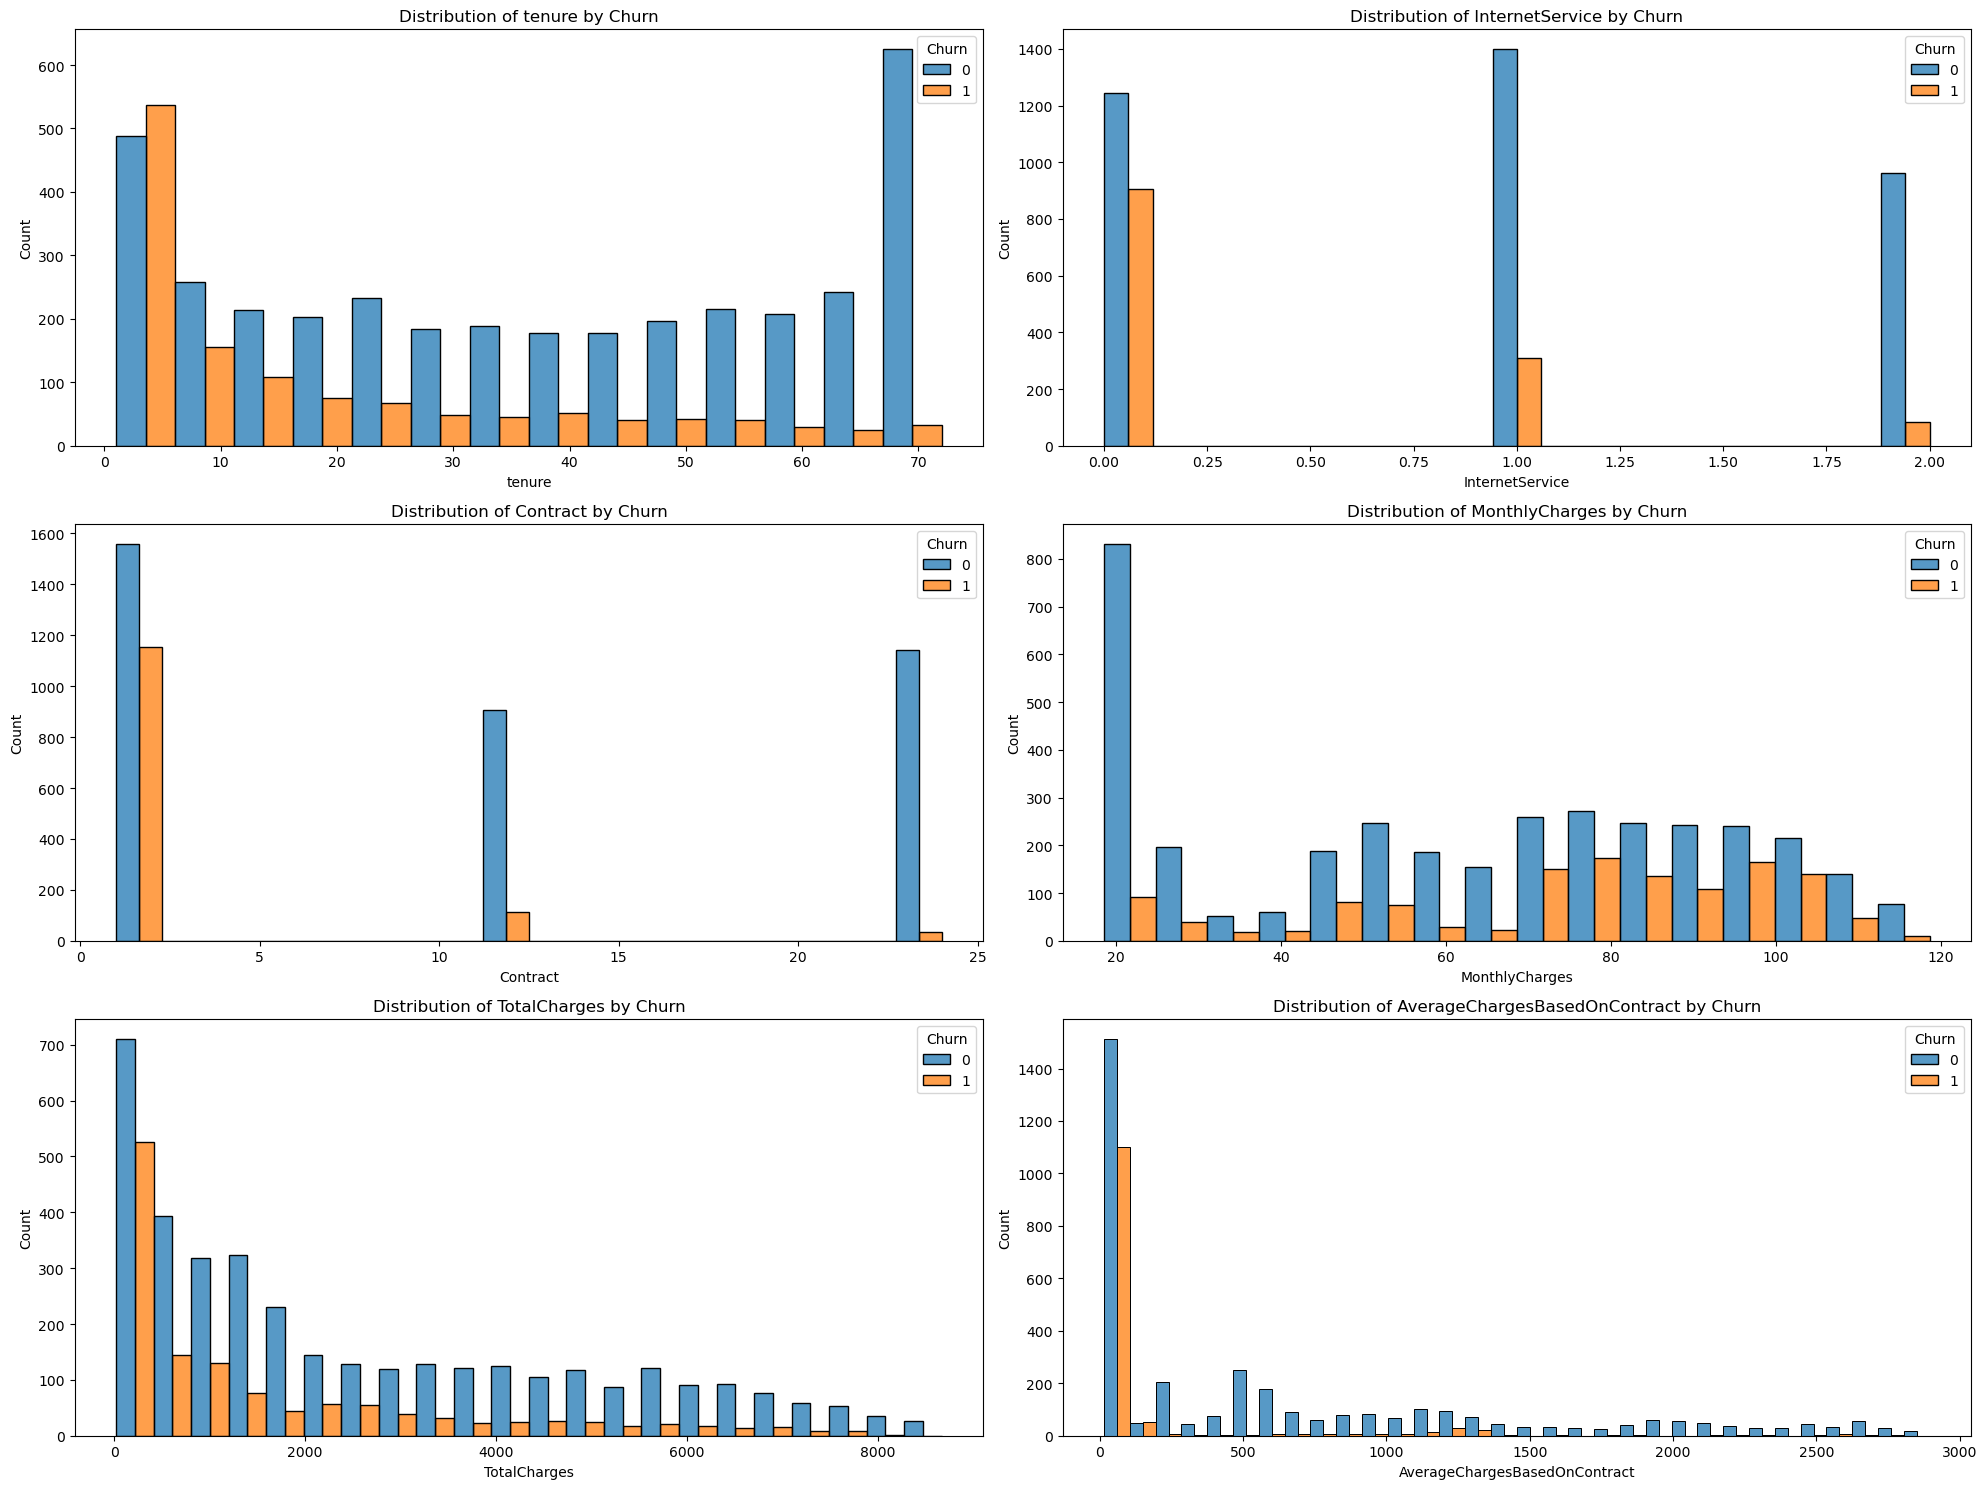

In [351]:
num_dodge_plot(train_data,non_binary_cols+["AverageChargesBasedOnContract"],"Churn")

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

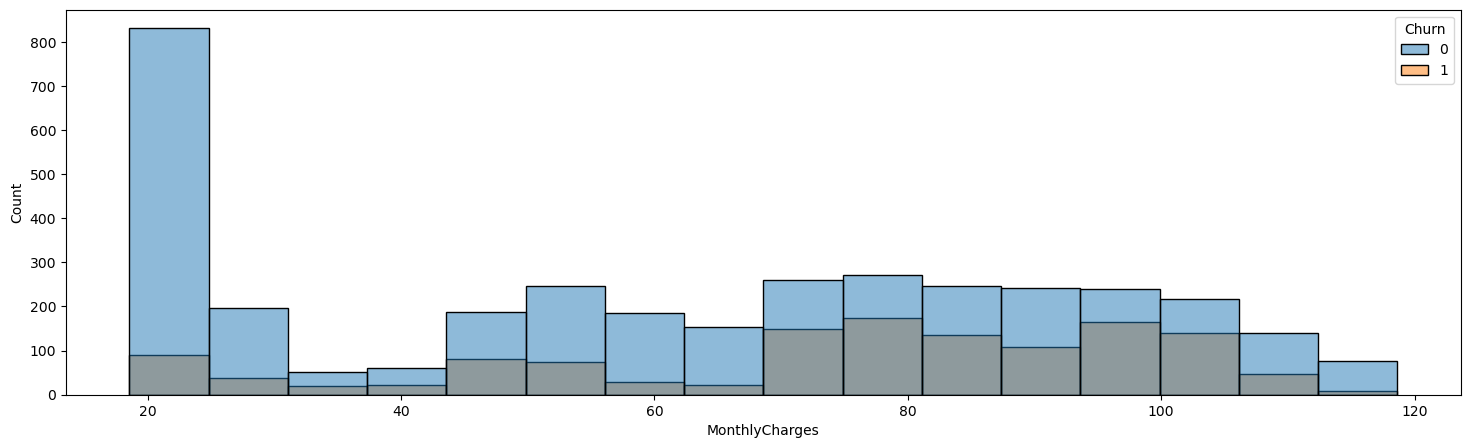

In [352]:
plt.figure(figsize=(18,5))
sns.histplot(train_data,x="MonthlyCharges",hue="Churn")

In [353]:
train_data=train_data.with_columns(train_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin")).drop("MonthlyCharges")
test_data=test_data.with_columns(test_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin")).drop("MonthlyCharges")

In [354]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2649276543713063

In [355]:
train_data.write_csv("../Day4_ErrorAnalysis/train_featureEngineered.csv")
test_data.write_csv("../Day4_ErrorAnalysis/test_featureEngineered.csv")

In [356]:
train_data.sample(5)

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,TotalCharges,Churn,StreamersWithTechSupport,Safer,Family,OnlinePayment,All,AverageChargesBasedOnContract,MonthlyChargesBin
str,i8,i8,i8,i8,i8,i8,f32,i8,i8,i8,i8,i8,i8,f32,i8
"""0379-DJQHR""",0,67,0,1,0,24,5398.600098,0,0,1,1,0,0,1933.826904,1
"""4878-BUNFV""",0,42,0,2,0,24,828.849976,0,0,0,1,0,0,473.628571,0
"""2672-HUYVI""",0,6,0,0,0,1,455.299988,1,0,0,0,1,0,75.883331,1
"""4697-LUPSU""",0,2,0,2,0,12,34.75,0,0,0,1,0,0,208.5,0
"""1849-RJYIG""",0,8,0,1,0,1,487.75,0,0,0,0,1,0,60.96875,0


In [357]:
train_data=train_data.with_columns(pl.Series(train_data["tenure"]/train_data["Contract"]).alias("ExpectedRechargeTimes"))
test_data=test_data.with_columns(pl.Series(test_data["tenure"]/test_data["Contract"]).alias("ExpectedRechargeTimes"))

In [358]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.svm import SVC
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'TotalCharges',
                                                   'StreamersWithTechSupport',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All',
                                                   'AverageChargesBasedOnContract',
                                                   'MonthlyChargesBin',
                                                   'ExpectedRechargeTimes'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.6492765437130625}))])

In [359]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Standard Deviation of Train roc auc Scores: {cv_results["train_roc_auc"].std()}')
print(f'Mean Train recall Score: {cv_results["train_recall"].mean()}')
print(f'Standard Deviation of Train recall Scores: {cv_results["train_recall"].std()}\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Standard Deviation of Test roc auc Scores: {cv_results["test_roc_auc"].std()}')
print(f'Mean Test recall Score: {cv_results["test_recall"].mean()}')
print(f'Standard Deviation of Test recall Scores: {cv_results["test_recall"].std()}')

Mean Train roc auc Score: 0.8415974600776259
Standard Deviation of Train roc auc Scores: 0.003009593258709286
Mean Train recall Score: 0.78875
Standard Deviation of Train recall Scores: 0.006407771954440823

Mean Test roc auc Score: 0.8385849833744772
Standard Deviation of Test roc auc Scores: 0.01200536033303436
Mean Test recall Score: 0.7843076923076925
Standard Deviation of Test recall Scores: 0.020809647284813427


In [360]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict
predictions= cross_val_predict(pipe,X_test,y_test,method='predict_proba')
predictions=[0 if x < 0.5 else 1 for x in predictions[:,1]]
print("logistic regression accuracy :",accuracy_score(y_true=y_test,y_pred=predictions))
print("auc roc",roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

logistic regression accuracy : 0.7556925996204934
auc roc 0.7686923218899964
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1548
           1       0.53      0.80      0.63       560

    accuracy                           0.76      2108
   macro avg       0.72      0.77      0.73      2108
weighted avg       0.81      0.76      0.77      2108



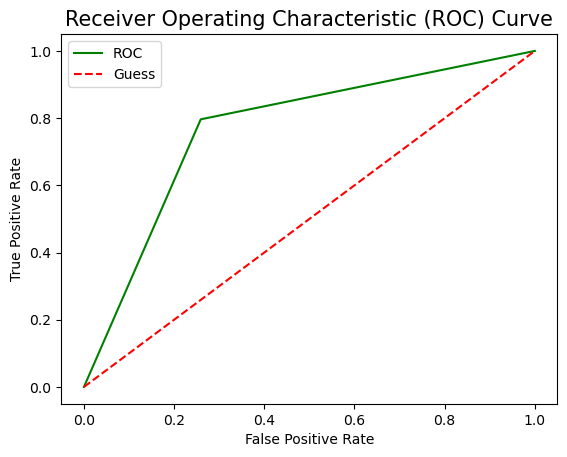

In [361]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test,predictions)
plot_roc_curve(fpr, tpr)

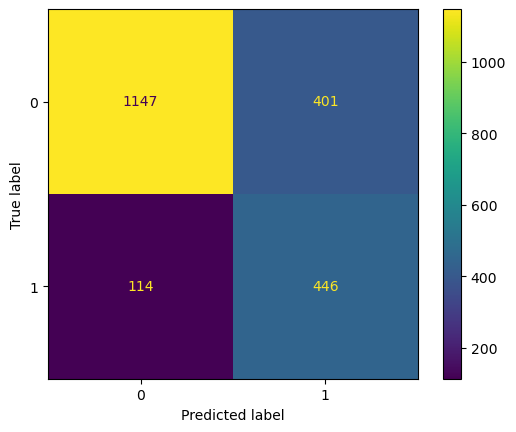

In [362]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [363]:
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
# Evaluation
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
precision = precision_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")

ROC AUC: 0.77
F1 Score: 0.63
Recall score: 0.80
precision : 0.53
Accuracy: 0.76
Corr : 0.4841339014661022


In [364]:
roc_auc,f1,recall,accuracy,coef

(0.7686923218899964,
 0.6339729921819474,
 0.7964285714285714,
 0.7556925996204934,
 0.4841339014661022)